### Prepare Dataset

<p>
<a href='http://www.paulgraham.com/articles.html' target='_blank'>Paul Graham Essays</a>
</p>

```python 
    import requests
    import bs4
    import json

    link = 'http://www.aaronsw.com/2002/feeds/pgessays.rss'
    res = requests.get(link)
    sp = bs4.BeautifulSoup(res.text)

    es_links = [[ele for ele in blck.get_text().split('\n') if ele][0]  for blck in sp.find_all('item') ]
    print('total essays:', len(es_links))

    def get_txt(link):
        try:
            res = requests.get(link)
            sp = bs4.BeautifulSoup(res.text)
            for br in sp('br'):
                br.replace_with('\n')
            return sp.find('body').find('table').find('font').get_text()
        except:
            print(f'failed: {link}')
    es_txts = [get_txt(link) for link in es_links]

    with open('./paulgraham_essays.json', 'w') as dest:
        dest.write(json.dumps([ele for ele in es_txts if ele]))
```

## RNN 

<p>
<a href='https://gist.github.com/karpathy/d4dee566867f8291f086' target='_blank'>Code Reference</a>
</p>

In [ ]:
import json
import numpy as np

### Load Dataset

<p>
 Let's take paulgraham essays and try to create language model using simple vanilla RNN.<br/>
 To keep it simple we use character level model to avoid big vocab size issue.
</p>

In [ ]:
with open('./paulgraham_essays.json', 'r') as f:
    data = json.loads(f.read())

In [ ]:
txts = ""
for ele in data:
    txts += ele + '\n'

In [ ]:
vocab = list(set(txts))
vocab_sz, n_char = len(vocab),len(txts)
print(f'vocab size:{vocab_sz}, data char size: {n_char}')

vocab size:103, data char size: 1845065


<p> Data char size is too big, let's try first small number of char size by truncating </p>

In [ ]:
max_sz = 10000
# txts = txts[:max_sz]
vocab = list(set(txts))
vocab_sz, n_char = len(vocab),len(txts)
print(f'vocab size:{vocab_sz}, data char size: {n_char}')

vocab size:69, data char size: 10000


### Model

<p style="line-height:2">
   * Our model is a simple RNN (Recurrent Nueural Netwrok) model. <br/>
   * RNN is speicific way of arranging neural network layers so that it can model sequence data like texts. <br/>
   * Usual feed-forward neural network (FNN) has problem with handling sequence data like texts, the problem is keeping track of dependencies in the sequence so that it can produce next element in the sequence, in the case of texts it may be next word/char.<br/>
   * problem-1: in FNN sequence order got destroyed, but order is important in sequence data like texts. <br/>
   * problem-2: FNN takes entire sequence in a single go but we need to input the sequence one element/char at a time and get the next predicted element/char in the sequence, so that we can train our model using the predicted element/char against actual next element/char in the sequence. if we want to do this in FNN then it will require variying input size but FNN requires pre-defined input and output size.<br/>
   * So basically RNN is just a modified version of FNN that can handle above mentioned problems and also able to train params using backpropagation.<br/>
   
</p>

#### Input and Label Structure

<p style="line-height:2">
    * We can't input entire sequence data into network, we need to split the sequence into multiple small chunks of sequence so that our system can handle one at a time.<br/>
    * Our goal for the model is it should take one element at a time and produce next element, so label will be the next element given the previous element. <br/>
    * Also we need to convert our each char into number, because we can't process raw text char, simple thing to do is assign unique int to each char in our vocab.
</p>

In [ ]:
char_to_idx = {ch:i for i,ch in enumerate(vocab)}
idx_to_char = {i:ch for ch,i in char_to_idx.items()}

In [ ]:
seq_sz = 25
inputs = txts[0:seq_sz]
targets = txts[1:seq_sz+1]

In [ ]:
inputs

'January 2023\n\n(Someone fe'

In [ ]:
targets

'anuary 2023\n\n(Someone fed'

#### Data Iterator

In [ ]:
def get_dls(txts, n_char, seq_sz):
    for i in range(n_char):
        if (i+seq_sz+1)>n_char:
            return ([], [])
        yield ([char_to_idx[ch] for ch in txts[i:i+seq_sz]], [char_to_idx[ch] for ch in txts[i+1:i+1+seq_sz]])

In [ ]:
dls = get_dls(txts, n_char, seq_sz)

In [ ]:
inputs,targets = next(dls)

In [ ]:
inputs[:4]

[11, 67, 21, 60]

In [ ]:
targets[:4]

[67, 21, 60, 67]

#### Model Parameters

<p style="line-height:2">
     * wxh : weights of the first hidden unit, this is basically normal FNN, this will take one element at a time. <br/>
     * whh : weights of the second hidden unit, which takes the output of the previous elements hidden layer output. <br/>
     * why : weights of the third hidden unit, which takes sum of the first two hidden units output as input and output the logits for the next chars. <br/>
                                                                                                 
</p>

In [ ]:
hidden_sz = 100
input_sz = vocab_sz # one-hot vector

In [ ]:
wxh = np.random.randn(hidden_sz,input_sz)*0.01
whh = np.random.randn(hidden_sz, hidden_sz)*0.01
why = np.random.randn(vocab_sz, hidden_sz)*0.01
bh = np.zeros((hidden_sz, 1))
by = np.zeros((vocab_sz, 1))

#### Forward Pass

In [ ]:
def forward(inputs, targets):
    allhs,alllogits,allps,alleles = {},{},{},{}
    allhs[-1] = np.zeros((hidden_sz, 1))
    loss = 0
    for t in range(len(inputs)):
        ele_t = np.zeros((vocab_sz, 1)) # one-hot representation
        ele_t[inputs[t]] = 1 
        alleles[t] = ele_t
        hs = np.tanh(np.dot(wxh, ele_t) + np.dot(whh, allhs[t-1]) + bh) # hidden state
        allhs[t] = hs
        logits = np.dot(why, hs) + by # raw score for each char
        alllogits[t] = logits
        ps = np.exp(logits)/np.sum(np.exp(logits)) # get probs for each char
        allps[t] = ps
        loss += -np.log(ps[targets[t]][0])
    return loss,allhs,alllogits,allps,alleles

In [ ]:
loss,*_ = forward(inputs, targets)

In [ ]:
loss

105.84598644365326

If we assume initialy that probability of picking correct char is from uniform distribution, we can estimate what would be the inital loss would be.

In [ ]:
-np.log(1/vocab_sz)*seq_sz

105.85266261493149

#### Calculate Gradient of the Loss Function based on Params

<p style="line-height:2">
    * Gradient is basically rate of change of the value based on params. here rate of change of loss based on our weight/bias.<br/>
    * This will inform us how much each weight/bias params influence the loss value if we change each one slightly. <br/>
    * We can use this information to change each weight/bias in the direction where it reduce the loss value. <br/>
    * But we can't directly use the gradient values to update weight/bias.
    
</p> 

##### Why can't  we use exact gradient to update the params?

<a href='https://youtu.be/o6FfdP2uYh4' target='_blank'>Cornell CS4780 SP17</a>

* Taylor expansion for the derivative.
* Function is convex or not.
* Taylor expansion holds for small learning rate.
* ADAGRAD.
* Newtons method.

##### Taylor expansion for the derivatives of the function.


<a href='https://www.khanacademy.org/math/ap-calculus-bc/bc-series-new/bc-10-11/v/maclaurin-and-taylor-series-intuition' target='_blank'>Finding Taylor polynomial approximations of functions</a>

https://math.stackexchange.com/questions/218421/what-are-the-practical-applications-of-the-taylor-series


<p> 
    
    * Basic idea of tylor series is to approximate any functions using polynomial functions using any single point in the original function.
    
    * Turns out if we try to approximate a function using polynomial function, we can do that by picking a particular point in our original function and take differentiation and put a constraint that polynomical function derivatives should match our original function at that point for every nth derivative of the original function and try to find the coefficients of the polynomials.
    
    * Interesting thing arises when we try to approximate original function with polynomial function is that it give raise to the property that is, if we know all the nth derivative of the original function at any particular point  then we can use these derivatives to approximate entire original function with the polynomial function, this approximated polynomial function will mimic the original function over all the points!.
    
    * One catch here is that we need all the nth derivative of the original function to approximate to the polynamial function but in practice it's difficult to get all nth derivative of the function. so we pick only few number of derivatives feasible to us. due this limitation, our approximated polynomial function will only be accurate around the point we selected initially but one interesting thing is in taylor series for each higher order terms denominator is in factorial so it will soon make the higher order terms zero and our series will converge with fewer higher order derivatives
    
    * Why we need polynomial aproximation of the function in the first place? the reason seems to be some functions are not easy function to handle but polynomial functions are just bunch of sums and products, so it make sense to convert the difficult fuction into polynomial function and work with them.
    
</p>

<div style='display:flex;'>
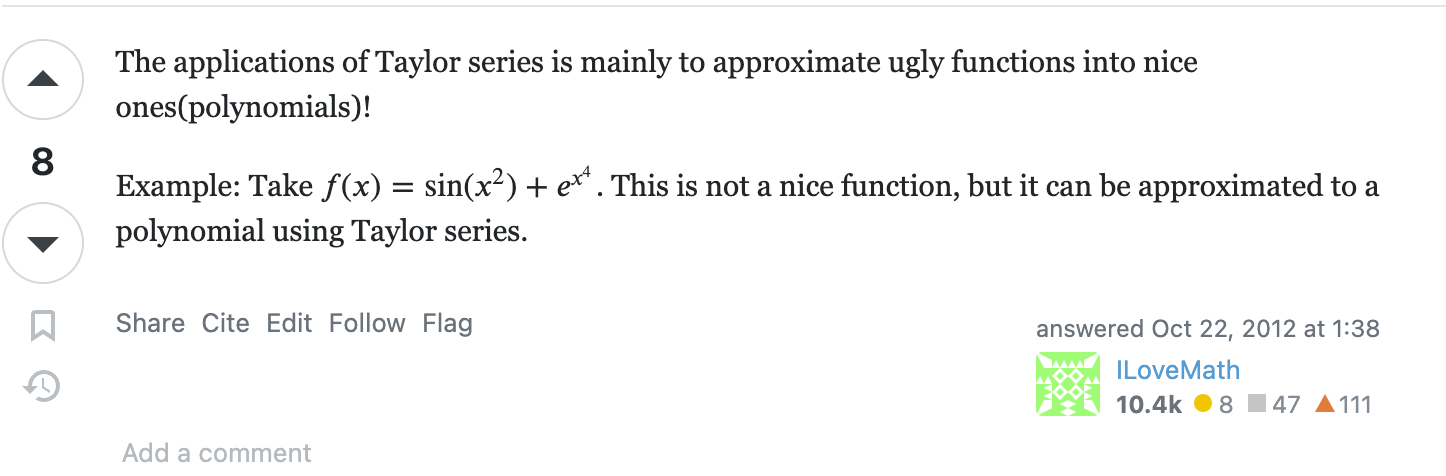
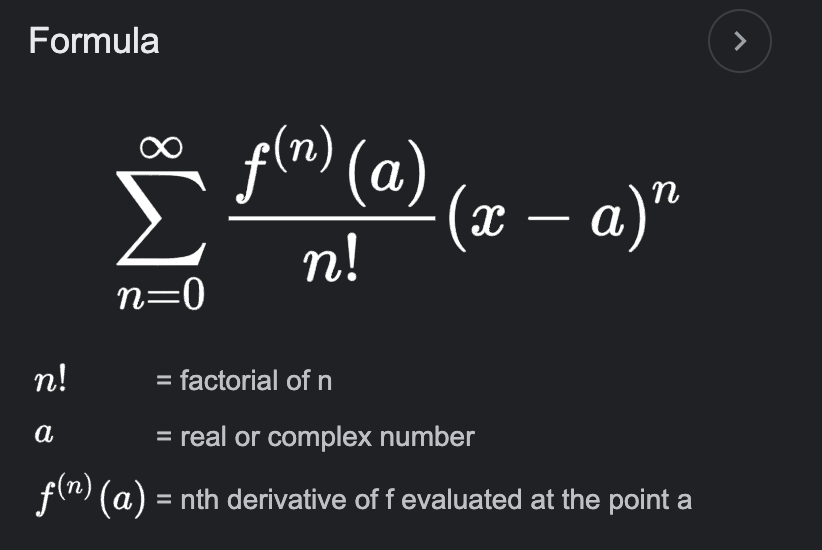
</div>

In [ ]:
def calc_grad(inputs, targets, allhs, alllogits, allps, alleles):
    # crete gradient holder for each params
    dwxh,dwhh,dwhy = np.zeros_like(wxh),np.zeros_like(whh),np.zeros_like(why)
    dbh = np.zeros_like(bh)
    dby = np.zeros_like(by)

    # also we need to keep track of gradient from the downstream operations in the sequence
    # becuase each hidden unit is used in subsequent layers
    dhnext = np.zeros_like(allhs[0]) # after end there won't be any operations

    # seq_size number of graidents are added to each params
    for t in reversed(range(len(inputs))):
        # based on cross-entropy graidient formula, logits are updated
        dy = np.copy(allps[t])
        dy[targets[t]] -=1
        # logits are created by wieghts why and hidden state output
        dwhy += np.dot(dy, allhs[t].T)
        dby += dy
        dh = np.dot(why.T, dy) + dhnext
        # now backprop through tanh (based on tanh gradient formula) 
        dhraw = (1-allhs[t]*allhs[t]) * dh
        dbh += dhraw
        dwxh += np.dot(dhraw, alleles[t].T)
        dwhh += np.dot(dhraw, allhs[t-1].T)
        dhnext = np.dot(whh.T, dhraw)

    # clip the size of the gradient to avoid gradient exploding
    for dparam in [dwxh, dwhh, dwhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return dwxh, dwhh, dwhy, dbh, dby, allhs[len(inputs)-1]

In [ ]:
loss,allhs,alllogits,allps,alleles = forward(inputs, targets)
dwxh,dwhh,dwhy,dbh,dby,hrprev = calc_grad(inputs, targets, allhs, alllogits, allps, alleles)

In [ ]:
# update params based on graident
lr = 1e-1
for param,dparam in zip([wxh,whh,why,bh,by], [dwxh, dwhh, dwhy, dbh, dby]):
    param -= lr*dparam

In [ ]:
loss,*_ = forward(inputs, targets)
loss

96.25472054020179

102 < 105, loss reduced! 

In [ ]:
from fastprogress import master_bar,progress_bar
import matplotlib.pyplot as plt

loss:78.484                                                                           


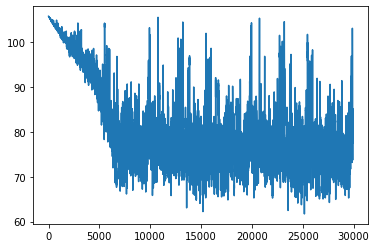

In [ ]:
wxh = np.random.randn(hidden_sz,input_sz)*0.01
whh = np.random.randn(hidden_sz, hidden_sz)*0.01
why = np.random.randn(vocab_sz, hidden_sz)*0.01
bh = np.zeros((hidden_sz, 1))
by = np.zeros((vocab_sz, 1))
lr = 1e-4
n_epochs = 3
mbar = master_bar(range(n_epochs))
losses = []
for epoch in mbar:
    dls = get_dls(txts, n_char, seq_sz)
    dls = [i for i in dls]
    for inputs,targets in progress_bar(dls, parent=mbar, leave=False):
            loss,allhs,alllogits,allps,alleles = forward(inputs, targets)
            dwxh,dwhh,dwhy,dbh,dby,hrprev = calc_grad(inputs, targets, allhs, alllogits, allps, alleles)
            # update params based on graident
            for param,dparam in zip([wxh,whh,why,bh,by], [dwxh, dwhh, dwhy, dbh, dby]):
                param += -lr*dparam
            losses.append(loss)
            
plt.plot(range(len(losses)), losses)
print(f'loss:{loss:.3f}')